In [57]:
# pythonでよく使われるライブラリ
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ニューラルネットワーク構築でよく使うライブラリ、他にもtfやkerasなど
import torch
import torch.nn as nn
import torchvision

# 画像分野でよく使われるライブラリ、他にopencvなどいろいろ
from PIL import Image
from IPython.display import display

torch.cuda.is_available()
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed(1)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# 1.  データ準備

In [39]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ])

# MNISTデータの取得
# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST
# 学習用
train_dataset = torchvision.datasets.MNIST(
    './data',               # データの保存先
    train = True,           # 学習用データを取得する
    download = True,        # データが無い時にダウンロードする
    transform = transform   # テンソルへの変換など
    )
# 評価用
test_dataset = torchvision.datasets.MNIST(
    './data', 
    train = False,
    transform = transform
    )

# データローダー
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 128,
    shuffle = True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,     
    batch_size = 128,
    shuffle = True)

### データセットの0番目を可視化

In [115]:
# データセット
data_0 = train_dataset[0]
image = data_0[0]
label = data_0[1]

tensor_to_pil = torchvision.transforms.ToPILImage()
img = tensor_to_pil(image)
display(img)
print("ラベル名称　： ", label)

ラベル名称　：  5


## 2.  モデル作成・定義

In [116]:
class CNN(nn.Module):
    def __init__(self): # , num_classes):
        super(CNN, self).__init__()
        self.conv_0 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
        self.classifier = nn.Linear(16*28*28, 10)

    def forward(self, x):
        x0 = self.conv_0(x)
        x0 = self.sigmoid(x0)
        x_view = x0.view(x0.size(0), -1)
        output = self.classifier(x_view)
        return output

In [117]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = CNN().to(device)

In [125]:
# 画像をバッチ化(ただの画像、一番最初に次元を一つ追加する必要がある)
image_batch = image.unsqueeze(0)
print(image.size(), "から", image_batch.size(), "\n")
# 出力結果
net(image_batch.to(device)).tolist()

torch.Size([1, 28, 28]) から torch.Size([1, 1, 28, 28]) 



[[0.13378402590751648,
  0.046661507338285446,
  -0.4594731628894806,
  0.01540127769112587,
  0.25467240810394287,
  -0.1130208894610405,
  -0.7830095291137695,
  -0.2249649465084076,
  0.22108715772628784,
  -0.24429981410503387]]

# 3. CNN学習

In [177]:
def CNNlearning(net, train_dataloader, epoch):
    set_seed(1)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # 学習率
    lr_set = 0.001
    # ロス関数
    criterion = torch.nn.CrossEntropyLoss()
    # 最適化アルゴリズム
    optimizer = torch.optim.SGD(net.parameters(), lr=lr_set)
    # ロスの減少を確認するためのリスト
    train_loss= []

    net.train()
    for e in range(epoch):
        loss = None
        net.zero_grad()
        optimizer.zero_grad()
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device) 
            labels = labels.to(device)

            # モデルに画像を入力して、出力(output)
            output = net(images)

            # モデルの出力とラベルでロス(誤差)を計算
            loss = criterion(output, labels)

            # 誤差から、最適なパラメータを求めに行く
            loss.backward()
            optimizer.step()

        # Lossの値を出力とリストへ追加 
        print(e, "epochのロス : ", loss.item())
        train_loss.append(loss.item())

    # 結果をプロット
    plt.figure()
    plt.plot(range(1, len(train_loss)+1), train_loss)
    plt.title('Training Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    return net

0 epochのロス :  0.6168243885040283
1 epochのロス :  0.5317970514297485
2 epochのロス :  0.23817168176174164
3 epochのロス :  0.34340253472328186
4 epochのロス :  0.3479878902435303


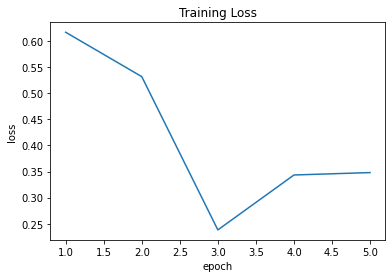

In [178]:
cnn = CNN().to(device)
trained_cnn = CNNlearning(cnn, train_dataloader, epoch=5)

# 4. CNNを推論

In [182]:
# データセット
data_0 = train_dataset[0]
image = data_0[0]
label = data_0[1]

tensor_to_pil = torchvision.transforms.ToPILImage()
img = tensor_to_pil(image)
display(img)
print("ラベル名称　： ", label)

# 画像をバッチ化(ただの画像、一番最初に次元を一つ追加する必要がある)
image_batch = image.unsqueeze(0)
# 出力結果
pred_output = trained_cnn(image_batch.to(device))
print("本当の出力 : ", pred_output.tolist())
print("推論結果 : ", torch.max(pred_output.data, 1)[1].item())

ラベル名称　：  5
本当の出力 :  [[-5.090204238891602, -3.6124279499053955, -9.53685188293457, 14.663860321044922, -7.253535270690918, 16.443328857421875, -11.356602668762207, 0.8943508267402649, 1.189014196395874, 3.7971625328063965]]
推論結果 :  5


# 5. 性能を評価

In [186]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def eval_func(net, test_dataloader):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  set_seed(1)
  net.eval()

  predlist = []
  labelist = []
  with torch.no_grad():
      set_seed(1)
      for i, (images, labels) in enumerate(test_dataloader):
          images = images.to(device)
          labels = labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          labelist += labels.tolist()
          predlist += predicted.tolist()
  acc = accuracy_score(predlist, labelist)
  return acc

In [187]:
"正解率", eval_func(trained_cnn, test_dataloader=train_dataloader)*100, "%"

('正解率', 90.25, '%')

In [188]:
"正解率", eval_func(trained_cnn, test_dataloader=test_dataloader)*100, "%"

('正解率', 90.27, '%')

# 6. 論文の貢献部分を実装

In [189]:
class update_CNN(nn.Module):
    def __init__(self): # , num_classes):
        super(update_CNN, self).__init__()
        self.conv_0 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.classifier = nn.Linear(16*28*28, 10)

        self.conv_1 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()

    def forward(self, x):
        x0 = self.conv_0(x)
        x0 = self.relu(x0)
        x1 = self.conv_1(x0)
        x1 = self.relu(x1)
        x_view = x1.view(x1.size(0), -1)
        x_view_dropout = self.dropout(x_view)
        output = self.classifier(x_view_dropout)
        return output

0 epochのロス :  0.3475196361541748
1 epochのロス :  0.26881399750709534
2 epochのロス :  0.14105449616909027
3 epochのロス :  0.2044583559036255
4 epochのロス :  0.20866991579532623


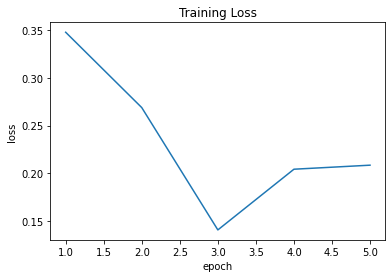

In [190]:
update_cnn = update_CNN().to(device)
trained_update_cnn = CNNlearning(update_cnn, train_dataloader, epoch=5)

# 7. もう一度、性能を評価

In [191]:
"正解率", eval_func(trained_update_cnn, test_dataloader=train_dataloader)*100, "%"

('正解率', 97.36833333333334, '%')

In [192]:
"正解率", eval_func(trained_update_cnn, test_dataloader=test_dataloader)*100, "%"

('正解率', 97.43, '%')